In [1]:
import json
import pandas as pd
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Initial Plots

In [2]:
df_311_selection_path = "data/311_selected_columns.pkl"
path_ctc_legend = "complaint_type_cls_legend.json"
path_ctc = "complaint_type_cls.json"

In [3]:
with open(path_ctc_legend) as fp_legend:
    ct_legend = json.load(fp_legend)
with open(path_ctc) as fp_data:
    ct_data = json.load(fp_data)

In [4]:
df_311_raw = pd.read_pickle(df_311_selection_path)
df_311_raw["Created Year"] = df_311_raw["Created Date"].dt.year
df_311_raw.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Latitude,Longitude,Created Year
0,32438412,2016-01-17 22:12:35,2016-01-17 23:14:02,NYPD,New York City Police Department,Noise - Residential,40.861404,-73.903217,2016
1,32438413,2016-01-17 15:23:56,2016-01-17 19:28:40,NYPD,New York City Police Department,Noise - Residential,40.841828,-73.937822,2016
2,32438414,2016-01-17 19:04:42,2016-01-19 08:49:00,DOT,Department of Transportation,Street Condition,40.761218,-73.912766,2016
3,32438415,2016-01-17 18:46:31,2016-01-17 19:51:41,NYPD,New York City Police Department,Noise - Commercial,40.651177,-73.941618,2016
4,32438416,2016-01-18 00:02:23,2016-01-18 16:51:22,NYPD,New York City Police Department,Noise - Residential,40.636969,-73.958533,2016


In [5]:
yearly_complaints = df_311_raw.groupby("Created Year") \
                              .count()["Created Date"]

In [6]:
def generate_plot(x, y):
    fig = go.Figure(
        data=go.Bar(
            x=x,
            y=y,
            marker=dict(
                color='rgb(250,128,114)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            text=y,
            textposition = 'auto',
            opacity=0.6),
        layout_title_text="Yearly complaints" 
    )
    fig.update_layout(template="plotly_dark")
    plotly.offline.plot(fig, filename='plots/complaints_per_year.html')
    
generate_plot(yearly_complaints.keys(), yearly_complaints.values)

In [9]:
complaint_types = df_311_raw.groupby("Complaint Type") \
                            .count()["Created Date"] \
                            .rename(columns={"Created Date": "Number of complaints"}) \
                            .sort_values(ascending=False)[:15]

In [10]:
def generate_plot(x, y):
    fig = go.Figure(
        data=go.Bar(
            x=x,
            y=y,
            orientation='h'),
        layout_title_text="Top 15 most frequent complaint types" 
    )
    fig.update_layout(template="plotly_dark")
    plotly.offline.plot(fig, filename='src/plots/top_complaints.html')
    
generate_plot(complaint_types.values[:20], complaint_types.keys()[:20])

In [11]:
df_311_raw["Complaint Type Class Index"] = df_311_raw["Complaint Type"].apply(lambda k: ct_data[k] if k in ct_data else -1)
ct_legend_inv = {v:k for k, v in ct_legend.items()}
df_311_raw["Complaint Type Class"] = df_311_raw["Complaint Type Class Index"].apply(lambda k: ct_legend_inv[k])
df_311_raw["Complaint Type Class"] = df_311_raw["Complaint Type Class"].astype("category")

In [12]:
complaint_type_classes = df_311_raw.groupby("Complaint Type Class") \
                                   .count()["Created Date"] \
                                   .reset_index()

complaint_type_classes = complaint_type_classes.rename(columns={"Created Date": "Count"})

In [13]:
def generate_plot(values, names):
    fig = go.Figure(
        data=go.Pie(
            values=values,
            labels=names
        ),
        layout_title_text="Distribution of complaint categories after labeling" 
    )
    fig.update_layout(template="plotly_dark")
    plotly.offline.plot(fig, filename='src/plots/complaint_type_categories.html')

generate_plot(complaint_type_classes['Count'], complaint_type_classes['Complaint Type Class'])

# Ranking NTAs

Short explanation

In [2]:
cleaned_311_path = "data/NTA_and_CTC_output.pkl"
nta_path = "data/Neighborhood Tabulation Areas.geojson"
nta_population_path = "data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv"

In [3]:
df_311 = pd.read_pickle(cleaned_311_path)
df_311["Complaint Type Class"] = df_311["Complaint Type Class"].astype("category")
df_311.head()

,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Latitude,Longitude,Complaint Type Class Index,Complaint Type Class,NTA
Unique Key,,,,,,,,,,
32438412,2016-01-17 22:12:35,2016-01-17 23:14:02,NYPD,New York City Police Department,Noise - Residential,40.861404,-73.903217,0,noise annoyance,BX30
32438413,2016-01-17 15:23:56,2016-01-17 19:28:40,NYPD,New York City Police Department,Noise - Residential,40.841828,-73.937822,0,noise annoyance,MN36
32438414,2016-01-17 19:04:42,2016-01-19 08:49:00,DOT,Department of Transportation,Street Condition,40.761218,-73.912766,2,public utility condition,QN70
32438415,2016-01-17 18:46:31,2016-01-17 19:51:41,NYPD,New York City Police Department,Noise - Commercial,40.651177,-73.941618,0,noise annoyance,BK91
32438416,2016-01-18 00:02:23,2016-01-18 16:51:22,NYPD,New York City Police Department,Noise - Residential,40.636969,-73.958533,0,noise annoyance,BK42


### Yearly evolution

In [4]:
# Add columns for date, weekday and hour of creation
df_311["Created Year"] = df_311["Created Date"].dt.year
df_311["Created Day"] = df_311["Created Date"].dt.date
df_311["Created Hour"] = df_311["Created Date"].dt.hour
df_311["Created Weekday"] = df_311["Created Date"].dt.dayofweek

df_311.head()

,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Latitude,Longitude,Complaint Type Class Index,Complaint Type Class,NTA,Created Year,Created Day,Created Hour,Created Weekday
Unique Key,,,,,,,,,,,,,,
32438412,2016-01-17 22:12:35,2016-01-17 23:14:02,NYPD,New York City Police Department,Noise - Residential,40.861404,-73.903217,0,noise annoyance,BX30,2016,2016-01-17,22,6
32438413,2016-01-17 15:23:56,2016-01-17 19:28:40,NYPD,New York City Police Department,Noise - Residential,40.841828,-73.937822,0,noise annoyance,MN36,2016,2016-01-17,15,6
32438414,2016-01-17 19:04:42,2016-01-19 08:49:00,DOT,Department of Transportation,Street Condition,40.761218,-73.912766,2,public utility condition,QN70,2016,2016-01-17,19,6
32438415,2016-01-17 18:46:31,2016-01-17 19:51:41,NYPD,New York City Police Department,Noise - Commercial,40.651177,-73.941618,0,noise annoyance,BK91,2016,2016-01-17,18,6
32438416,2016-01-18 00:02:23,2016-01-18 16:51:22,NYPD,New York City Police Department,Noise - Residential,40.636969,-73.958533,0,noise annoyance,BK42,2016,2016-01-18,0,0


In [5]:
yearly_complaints = df_311.groupby("Created Year") \
                          .count()["Created Date"] \
                          .reset_index() \
                          .rename(columns={"Created Date": "Yearly complaints"})

### Neighborhood Tabulation Areas (NTAs)

In [6]:
nta_pop_df = pd.read_csv(nta_population_path)
nta_pop_df = nta_pop_df[nta_pop_df["Year"] == 2010][["NTA Code", "NTA Name", "Population"]].set_index("NTA Code")

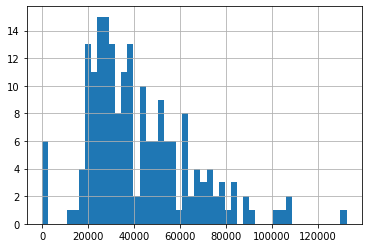

In [7]:
nta_pop_df.sort_values(by="Population")["Population"].hist(bins=50);

In [8]:
nta_pop_df[nta_pop_df.Population < 12000]

,NTA Name,Population
NTA Code,,
BX98,Rikers Island,11091
BX99,park-cemetery-etc-Bronx,1906
BK99,park-cemetery-etc-Brooklyn,418
MN99,park-cemetery-etc-Manhattan,1849
QN98,Airport,0
QN99,park-cemetery-etc-Queens,436
SI99,park-cemetery-etc-Staten Island,0


In [9]:
nta_pop_df[nta_pop_df.Population > 12000].sort_values("Population")

,NTA Name,Population
NTA Code,,
BK93,Starrett City,13354
SI14,Grasmere-Arrochar-Ft. Wadsworth,16079
SI35,New Brighton-Silver Lake,17525
BK23,West Brighton,17750
QN41,Fresh Meadows-Utopia,17812
...,...,...
BK61,Crown Heights North,103169
BK42,Flatbush,105804
BK88,Borough Park,106357


In [10]:
invalid_ntas = nta_pop_df[nta_pop_df.Population < 12000].index.tolist()

In [11]:
invalid_ntas

['BX98', 'BX99', 'BK99', 'MN99', 'QN98', 'QN99', 'SI99']

In [12]:
df_311 = df_311[~df_311.NTA.isin(invalid_ntas)]
df_311.head()

,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Latitude,Longitude,Complaint Type Class Index,Complaint Type Class,NTA,Created Year,Created Day,Created Hour,Created Weekday
Unique Key,,,,,,,,,,,,,,
32438412,2016-01-17 22:12:35,2016-01-17 23:14:02,NYPD,New York City Police Department,Noise - Residential,40.861404,-73.903217,0,noise annoyance,BX30,2016,2016-01-17,22,6
32438413,2016-01-17 15:23:56,2016-01-17 19:28:40,NYPD,New York City Police Department,Noise - Residential,40.841828,-73.937822,0,noise annoyance,MN36,2016,2016-01-17,15,6
32438414,2016-01-17 19:04:42,2016-01-19 08:49:00,DOT,Department of Transportation,Street Condition,40.761218,-73.912766,2,public utility condition,QN70,2016,2016-01-17,19,6
32438415,2016-01-17 18:46:31,2016-01-17 19:51:41,NYPD,New York City Police Department,Noise - Commercial,40.651177,-73.941618,0,noise annoyance,BK91,2016,2016-01-17,18,6
32438416,2016-01-18 00:02:23,2016-01-18 16:51:22,NYPD,New York City Police Department,Noise - Residential,40.636969,-73.958533,0,noise annoyance,BK42,2016,2016-01-18,0,0


### Ranking

In [13]:
nta_complaints = df_311.groupby("NTA") \
                       .count()["Created Date"] \
                       .reset_index() \
                       .rename(columns={"Created Date": "Number of complaints"})

In [14]:
nta_complaints = nta_complaints.merge(nta_pop_df, left_on="NTA", right_index=True).set_index("NTA")
nta_complaints["Complaints per 30k capita"] = 30000 * nta_complaints["Number of complaints"] / nta_complaints["Population"]
nta_complaints["Number of complaints rank"] = nta_complaints["Number of complaints"].rank(method="first")
nta_complaints["Complaints per 30k capita rank"] = nta_complaints["Complaints per 30k capita"].rank(method="first")
nta_complaints = nta_complaints.sort_values(by="Complaints per 30k capita rank")
nta_complaints.head(20)

,Number of complaints,NTA Name,Population,Complaints per 30k capita,Number of complaints rank,Complaints per 30k capita rank
NTA,,,,,,
MN50,11266,Stuyvesant Town-Cooper Village,21049,16056.819801,2.0,1.0
BK93,8148,Starrett City,13354,18304.627827,1.0,2.0
BK23,11575,West Brighton,17750,19563.380282,3.0,3.0
BX13,33298,Co-Op City,43752,22831.870543,8.0,4.0
BK72,32880,Williamsburg,32926,29958.087833,7.0,5.0
QN47,27031,Ft. Totten-Bay Terrace-Clearview,21751,37282.423797,4.0,6.0
MN31,100404,Lenox Hill-Roosevelt Island,80771,37292.097411,111.0,7.0
BX46,37322,Parkchester,29821,37546.024614,11.0,8.0
QN25,76642,Corona,57658,39877.553852,73.0,9.0


In [15]:
nta_yearly_complaints = df_311.groupby(["NTA", "Created Year"]) \
                              .count()["Created Date"] \
                              .reset_index() \
                              .rename(columns={"Created Date": "Total complaints"})
nta_yearly_complaints = nta_yearly_complaints.merge(yearly_complaints, on="Created Year")
nta_yearly_complaints = nta_yearly_complaints.merge(nta_pop_df, left_on="NTA", right_index=True)
nta_yearly_complaints.head()

,NTA,Created Year,Total complaints,Yearly complaints,NTA Name,Population
0,BK09,2010,3535,1776931,Brooklyn Heights-Cobble Hill,22887
188,BK09,2011,3331,1706950,Brooklyn Heights-Cobble Hill,22887
376,BK09,2012,3559,1586276,Brooklyn Heights-Cobble Hill,22887
564,BK09,2013,3440,1614172,Brooklyn Heights-Cobble Hill,22887
752,BK09,2014,4287,1907305,Brooklyn Heights-Cobble Hill,22887


In [16]:
nta_yearly_complaints["Complaints per 30k capita"] = 30000 * nta_yearly_complaints["Total complaints"] / nta_yearly_complaints["Population"]
nta_yearly_complaints.head()

,NTA,Created Year,Total complaints,Yearly complaints,NTA Name,Population,Complaints per 30k capita
0,BK09,2010,3535,1776931,Brooklyn Heights-Cobble Hill,22887,4633.634815
188,BK09,2011,3331,1706950,Brooklyn Heights-Cobble Hill,22887,4366.234107
376,BK09,2012,3559,1586276,Brooklyn Heights-Cobble Hill,22887,4665.093721
564,BK09,2013,3440,1614172,Brooklyn Heights-Cobble Hill,22887,4509.109975
752,BK09,2014,4287,1907305,Brooklyn Heights-Cobble Hill,22887,5619.347228


In [17]:
years = nta_yearly_complaints["Created Year"].unique().tolist()
complaints_per_capita_sum = {}
for year in years:
    yearly_complaints = nta_yearly_complaints[nta_yearly_complaints["Created Year"] == year]
    complaints_per_capita_sum[year] = yearly_complaints["Complaints per 30k capita"].sum()
    
print(complaints_per_capita_sum)

{2010: 1214326.6570697855, 2011: 1165223.0102775632, 2012: 1087563.7537011965, 2013: 1099574.264425634, 2014: 1300096.006828691, 2015: 1414253.9620821073, 2016: 1491803.0028707634, 2017: 1571455.8822921258, 2018: 1762230.2769213584, 2019: 1345101.1900743307}


In [18]:
nta_yearly_complaints["Complaints per 30k capita"] = 30000 * nta_yearly_complaints["Total complaints"] / nta_yearly_complaints["Population"]
nta_yearly_complaints["Fraction of yearly complaints per 30k capita"] = 100 * nta_yearly_complaints.apply(lambda r: r["Complaints per 30k capita"] / complaints_per_capita_sum[r["Created Year"]], axis=1)
nta_yearly_complaints.sort_values("Fraction of yearly complaints per 30k capita", ascending=False)
nta_yearly_complaints.head()

,NTA,Created Year,Total complaints,Yearly complaints,NTA Name,Population,Complaints per 30k capita,Fraction of yearly complaints per 30k capita
0,BK09,2010,3535,1776931,Brooklyn Heights-Cobble Hill,22887,4633.634815,0.381581
188,BK09,2011,3331,1706950,Brooklyn Heights-Cobble Hill,22887,4366.234107,0.374712
376,BK09,2012,3559,1586276,Brooklyn Heights-Cobble Hill,22887,4665.093721,0.428949
564,BK09,2013,3440,1614172,Brooklyn Heights-Cobble Hill,22887,4509.109975,0.410078
752,BK09,2014,4287,1907305,Brooklyn Heights-Cobble Hill,22887,5619.347228,0.432226


In [19]:
nta_yearly_complaints[nta_yearly_complaints["Created Year"] == 2019]["Fraction of yearly complaints per 30k capita"].sum()

100.0

In [20]:
# Sanity check
nta_yearly_complaints[nta_yearly_complaints.NTA == "MN17"]

,NTA,Created Year,Total complaints,Yearly complaints,NTA Name,Population,Complaints per 30k capita,Fraction of yearly complaints per 30k capita
96,MN17,2010,17126,1776931,Midtown-Midtown South,28630,17945.511701,1.477816
284,MN17,2011,16238,1706950,Midtown-Midtown South,28630,17015.019211,1.460237
472,MN17,2012,16948,1586276,Midtown-Midtown South,28630,17758.994062,1.632915
660,MN17,2013,18069,1614172,Midtown-Midtown South,28630,18933.636046,1.721906
848,MN17,2014,18788,1907305,Midtown-Midtown South,28630,19687.041565,1.514276
1036,MN17,2015,21233,2073427,Midtown-Midtown South,28630,22249.039469,1.573200
1224,MN17,2016,30074,2181309,Midtown-Midtown South,28630,31513.098149,2.112417
1412,MN17,2017,24711,2285017,Midtown-Midtown South,28630,25893.468390,1.647738
1600,MN17,2018,24826,2545807,Midtown-Midtown South,28630,26013.971359,1.476196
1788,MN17,2019,20129,1942202,Midtown-Midtown South,28630,21092.210968,1.568076


# Not in the final report

In [21]:
df_311["Complaint Type Class"].unique().tolist()

['noise annoyance',
 'public utility condition',
 'human activity disturbance',
 'private property condition',
 'general/miscellaneous',
 'pest',
 'unclassified',
 'taxation or advantage program related']

In [22]:
complaint_type_classes = df_311.groupby("Complaint Type Class") \
                               .count()["Created Date"] \
                               .sort_values(ascending=False)

complaint_type_classes

Complaint Type Class
private property condition               7160573
public utility condition                 3955703
noise annoyance                          3791740
human activity disturbance               3607686
general/miscellaneous                     669522
pest                                      307682
unclassified                               18096
taxation or advantage program related      15461
Name: Created Date, dtype: int64

**Focus on top-4 complaint classes**.

In [23]:
selected_classes = complaint_type_classes.index.tolist()[:4]

In [24]:
nta_complaints_per_class = df_311[df_311["Complaint Type Class"].isin(selected_classes)] \
                                 .groupby(["NTA", "Complaint Type Class"]) \
                                 .count()["Created Date"] \
                                 .reset_index() \
                                 .rename(columns={"Created Date": "Number of complaints"}) \
                                 .dropna()
nta_complaints_per_class.head()

,NTA,Complaint Type Class,Number of complaints
1,BK09,human activity disturbance,9175.0
2,BK09,noise annoyance,9364.0
4,BK09,private property condition,10792.0
5,BK09,public utility condition,13138.0
9,BK17,human activity disturbance,28217.0


In [25]:
nta_complaints_per_class = nta_complaints_per_class.merge(nta_pop_df, left_on="NTA", right_index=True)
nta_complaints_per_class["Complaints per capita"] = nta_complaints_per_class["Number of complaints"] / nta_complaints_per_class["Population"]
nta_complaints_per_class.head()

,NTA,Complaint Type Class,Number of complaints,NTA Name,Population,Complaints per capita
1,BK09,human activity disturbance,9175.0,Brooklyn Heights-Cobble Hill,22887,0.400883
2,BK09,noise annoyance,9364.0,Brooklyn Heights-Cobble Hill,22887,0.409141
4,BK09,private property condition,10792.0,Brooklyn Heights-Cobble Hill,22887,0.471534
5,BK09,public utility condition,13138.0,Brooklyn Heights-Cobble Hill,22887,0.574038
9,BK17,human activity disturbance,28217.0,Sheepshead Bay-Gerritsen Beach-Manhattn Bch,64518,0.437351


In [26]:
test_df = nta_complaints_per_class[["NTA Name", "Complaint Type Class","Complaints per capita"]].pivot(index="NTA Name", columns="Complaint Type Class", values="Complaints per capita")
test_df.head()

Complaint Type Class,human activity disturbance,noise annoyance,private property condition,public utility condition
NTA Name,,,,
Allerton-Pelham Gardens,0.398851,0.246168,0.502024,0.669377
Annadale-Huguenot-Prince's Bay-Eltingville,0.452143,0.115268,0.471228,1.073100
Arden Heights,0.442983,0.092400,0.340598,0.706157
Astoria,0.512279,0.471831,0.592984,0.449329
Auburndale,0.538158,0.118124,0.406531,0.984247


In [27]:
selected_ntas = nta_complaints["NTA Name"].values.tolist()[:25]
test_df = test_df.loc[selected_ntas]

In [28]:
complaint_fractions = test_df.to_numpy().T

In [29]:
def generate_plot(x, y, z):
    fig = go.Figure(data=go.Heatmap(
            z=z,
            x=x,
            y=y,
            colorscale='Viridis'))

    fig.update_layout(title="To be defined", template="plotly_dark")
    plotly.offline.plot(fig, filename='plots/test.html')
    
generate_plot(selected_ntas, selected_classes, complaint_fractions)

# Box-plot of resolution times